In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import re
import string

import nltk
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

import mglearn

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from IPython.lib.display import Audio


## Text Pre-Processing

In [2]:
df = pd.read_csv('data/tweet_data.csv')

In [3]:
df.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785916 entries, 0 to 785915
Data columns (total 18 columns):
tweetID       785916 non-null int64
crDate        785916 non-null object
edInput       785916 non-null int64
editor        785916 non-null int64
engages       785916 non-null int64
isApproved    785916 non-null bool
isEdNeed      785916 non-null bool
isRT          785916 non-null bool
likes         785916 non-null int64
photoUrl      277896 non-null object
retweets      785916 non-null int64
rtUsID        785916 non-null int64
text          785916 non-null object
topicName     785916 non-null object
usFlwrs       785916 non-null int64
usID          785916 non-null int64
usName        785916 non-null object
videoUrl      140491 non-null object
dtypes: bool(3), int64(9), object(6)
memory usage: 92.2+ MB


In [5]:
df.describe()

,tweetID,edInput,editor,engages,likes,retweets,rtUsID,usFlwrs,usID
count,7.859160e+05,785916.000000,785916.000000,7.859160e+05,7.859160e+05,7.859160e+05,7.859160e+05,7.859160e+05,7.859160e+05
mean,1.115213e+18,0.206035,2311.963123,1.403637e+03,1.085909e+03,3.177282e+02,4.365098e+16,4.472701e+06,1.085276e+17
std,2.925292e+16,1.439867,2495.158883,1.665960e+04,1.293993e+04,4.053267e+03,1.894384e+17,9.149778e+06,3.010486e+17
min,5.354500e+04,-1.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,1.200000e+01
25%,1.095791e+18,-1.000000,-1.000000,2.300000e+01,1.600000e+01,6.000000e+00,-1.000000e+00,1.426280e+05,1.551377e+07
50%,1.116465e+18,-1.000000,-1.000000,6.400000e+01,4.500000e+01,1.800000e+01,-1.000000e+00,9.668265e+05,3.618422e+07
75%,1.137676e+18,1.000000,5003.000000,2.500000e+02,1.840000e+02,6.500000e+01,-1.000000e+00,3.603135e+06,9.545908e+08
max,1.154179e+18,4.000000,5101.000000,4.152927e+06,3.206434e+06,1.335638e+06,1.108957e+18,1.057384e+08,1.153467e+18


In [6]:
df.columns

Index(['tweetID', 'crDate', 'edInput', 'editor', 'engages', 'isApproved',
       'isEdNeed', 'isRT', 'likes', 'photoUrl', 'retweets', 'rtUsID', 'text',
       'topicName', 'usFlwrs', 'usID', 'usName', 'videoUrl'],
      dtype='object')

In [7]:
df['topicName'].unique()

array(['Business', 'Animal', 'Memes', 'Nature', 'Travel', 'Interesting',
       'News', 'Fashion', 'Art', 'Personal Development', 'Motivational',
       'DIY & Craft', 'Editorial Pics', 'Funny', 'Poem', 'World Leaders',
       'Entrepreneurship', 'US News', 'Journalists', 'Flowers',
       'Cryptocurrency', 'Photography', 'Design & Architecture',
       'Fitness', 'Spirituality', 'Startup', 'Space', 'Technology',
       'Digital Media & Internet', 'Psychology', 'Science', 'Basketball',
       'Humor', 'Mindfulness', 'Medical', 'Informative', 'Love', 'Stocks',
       'Nanotech', 'Biotech', 'science', 'Random'], dtype=object)

### Select Business Data

In [12]:
df_business = df[df['topicName']=='Business']

In [13]:
df_business.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...


In [14]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164602 entries, 0 to 785869
Data columns (total 18 columns):
tweetID       164602 non-null int64
crDate        164602 non-null object
edInput       164602 non-null int64
editor        164602 non-null int64
engages       164602 non-null int64
isApproved    164602 non-null bool
isEdNeed      164602 non-null bool
isRT          164602 non-null bool
likes         164602 non-null int64
photoUrl      20134 non-null object
retweets      164602 non-null int64
rtUsID        164602 non-null int64
text          164602 non-null object
topicName     164602 non-null object
usFlwrs       164602 non-null int64
usID          164602 non-null int64
usName        164602 non-null object
videoUrl      25446 non-null object
dtypes: bool(3), int64(9), object(6)
memory usage: 20.6+ MB


In [15]:
df_business.columns

Index(['tweetID', 'crDate', 'edInput', 'editor', 'engages', 'isApproved',
       'isEdNeed', 'isRT', 'likes', 'photoUrl', 'retweets', 'rtUsID', 'text',
       'topicName', 'usFlwrs', 'usID', 'usName', 'videoUrl'],
      dtype='object')

In [16]:
df_business = df_business.drop(['photoUrl', 'videoUrl'], axis = 1)

In [17]:
df_business.columns

Index(['tweetID', 'crDate', 'edInput', 'editor', 'engages', 'isApproved',
       'isEdNeed', 'isRT', 'likes', 'retweets', 'rtUsID', 'text', 'topicName',
       'usFlwrs', 'usID', 'usName'],
      dtype='object')

In [18]:
df_business['edInput'].value_counts()

-1    123309
 1     17836
 2     12188
 4     10721
 3       548
Name: edInput, dtype: int64

In [19]:
df_business['edInput'] != -1

0         False
1         False
2         False
3         False
4         False
          ...  
785813     True
785817    False
785829     True
785854     True
785869    False
Name: edInput, Length: 164602, dtype: bool

In [20]:
# https://www.statology.org/pandas-drop-rows-with-value/
df_business = df_business[df_business['edInput'].isin([-1, 3, 4])==False]

In [21]:
df_business['edInput'].value_counts()

1    17836
2    12188
Name: edInput, dtype: int64

In [22]:
df_business['label'] = df_business['edInput'].apply(
    lambda label: 1 if label == 1 else 0)

In [23]:
df_business.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,label
12252,1072758722315862021,2018-12-12 07:43:04,2,5001,9618,False,True,True,5771,3847,621523,UK Prime Minister Theresa May will face a vote...,Business,38564612,5402612,BBC Breaking News,0
14042,1072959907958276096,2018-12-12 21:02:31,2,5001,10388,False,True,True,6977,3411,621523,UK PM Theresa May wins confidence vote with 20...,Business,38567131,5402612,BBC Breaking News,0
16954,1073329348755767303,2018-12-13 21:30:32,2,5001,6734,False,True,True,4467,2267,3108351,The probe of the inaugural fund partly arises ...,Business,57108,705706292,Rebecca Ballhaus,0
18004,1073499538659393536,2018-12-14 08:46:49,1,5001,6914,True,True,True,5402,1512,621523,The week Brexit hit the brick wall : Commons ...,Business,879928,25984418,Nick Robinson,1
18396,1073542862573371392,2018-12-14 11:38:58,2,5001,6269,False,True,True,4610,1659,621523,Have watched these kinds of pictures looking f...,Business,888862,61183568,Laura Kuenssberg,0


In [24]:
df_business['label'].value_counts()

1    17836
0    12188
Name: label, dtype: int64

In [26]:
df_business_label = df_business[['text', 'label', 'engages', 'likes', 'retweets', 'usFlwrs', 'usName']]

In [27]:
df_business_label.head()

,text,label,engages,likes,retweets,usFlwrs,usName
12252,UK Prime Minister Theresa May will face a vote...,0,9618,5771,3847,38564612,BBC Breaking News
14042,UK PM Theresa May wins confidence vote with 20...,0,10388,6977,3411,38567131,BBC Breaking News
16954,The probe of the inaugural fund partly arises ...,0,6734,4467,2267,57108,Rebecca Ballhaus
18004,The week Brexit hit the brick wall : Commons ...,1,6914,5402,1512,879928,Nick Robinson
18396,Have watched these kinds of pictures looking f...,0,6269,4610,1659,888862,Laura Kuenssberg


In [28]:
df_business_label[df_business_label['label']==1].head()

,text,label,engages,likes,retweets,usFlwrs,usName
18004,The week Brexit hit the brick wall : Commons ...,1,6914,5402,1512,879928,Nick Robinson
26068,"“This is Pearl Harbor. The whole country, and ...",1,6284,5207,1077,12423,Saikat Chakrabarti
29792,"Pursue your ideas, no matter how obvious they ...",1,786,548,238,5376604,Harvard Biz Review
29959,You don’t have to choose between being a leade...,1,664,436,228,5376647,Harvard Biz Review
30072,Add a second monitor for your laptop https://t...,1,898,617,281,202145,Tech Insider


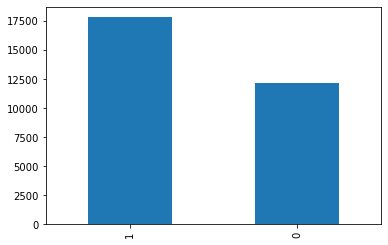

In [29]:
df_business_label['label'].value_counts().plot(kind='bar')

### Select text that exists in English "dictionary" - 'clean text'

In [30]:
# nltk.download('words')
words = set(nltk.corpus.words.words())

In [31]:
def preprocess_text(my_text):
    """
    Take in column (pandas series) of text and return 'cleaned' text
    
    Input: column of text
    Output: column of cleaned text
    """
    new_text = []
    
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    
    alpha_lower = my_text.map(alphanumeric).map(punc_lower)
    
    for item in alpha_lower:
        new_text.append(" ".join(w for w in nltk.wordpunct_tokenize(item) if w.lower() in words or not w.isalpha()))
        
    return new_text

In [32]:
df_business_label['clean_text'] = preprocess_text(df_business_label['text'])

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df_business_label

,text,label,engages,likes,retweets,usFlwrs,usName,clean_text
12252,UK Prime Minister Theresa May will face a vote...,0,9618,5771,3847,38564612,BBC Breaking News,prime minister may will face a vote of no conf...
14042,UK PM Theresa May wins confidence vote with 20...,0,10388,6977,3411,38567131,BBC Breaking News,may confidence vote with out of tory supportin...
16954,The probe of the inaugural fund partly arises ...,0,6734,4467,2267,57108,Rebecca Ballhaus,the probe of the inaugural fund partly out of ...
18004,The week Brexit hit the brick wall : Commons ...,1,6914,5402,1512,879928,Nick Robinson,the week hit the brick wall commons won ’ t ac...
18396,Have watched these kinds of pictures looking f...,0,6269,4610,1659,888862,Laura Kuenssberg,have watched these of looking for body languag...
...,...,...,...,...,...,...,...,...
785779,This bouquet of roses is completely edible htt...,0,431,321,110,214469,FOOD INSIDER,this bouquet of is completely edible t
785809,This fancy McDonald's has a handwashing statio...,0,699,504,195,214487,FOOD INSIDER,this fancy s a station and real silverware 🍴 t
785813,🚨 Spoilers ahead 🚨\nFinished #StrangerThings? ...,0,135,101,34,16441,Kim Renfro,🚨 ahead 🚨 finished great let s dive into some ...
785829,These cakes are topped with yogurt 🎂 https://t...,0,1892,1412,480,214530,FOOD INSIDER,these are topped with 🎂 t


In [34]:
more_words = ['rt', 'rts', 'retweet']
s_words = set().union(stopwords.words('english'), more_words)

### Alternatively, removed unwanted items and stopwords: 'processed text'

In [35]:
df_business_label['processed_text'] = df_business_label['text'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in s_words])

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df_business_label['processed_text'] = df_business_label['processed_text'].apply(" ".join)

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
df_business_label['processed_text']

12252     uk prime minister theresa may face vote confid...
14042     uk pm theresa may wins confidence vote 200 317...
16954     probe inaugural fund partly arises materials s...
18004     week brexit hit brick wall commons accept may ...
18396     watched kinds pictures looking body language b...
                                ...                        
785779                      bouquet roses completely edible
785809    fancy mcdonald handwashing station real silver...
785813    spoilers ahead finished strangerthings great l...
785829                                  cakes topped yogurt
785854                              team shake shack team n
Name: processed_text, Length: 30024, dtype: object

In [38]:
df_business_label['processed_text'].duplicated()

12252     False
14042     False
16954     False
18004     False
18396     False
          ...  
785779    False
785809    False
785813    False
785829    False
785854    False
Name: processed_text, Length: 30024, dtype: bool

### Remove duplicated text rows

In [39]:
bool_series = df_business_label['processed_text'].duplicated()

In [40]:
df_business_label[~bool_series]

,text,label,engages,likes,retweets,usFlwrs,usName,clean_text,processed_text
12252,UK Prime Minister Theresa May will face a vote...,0,9618,5771,3847,38564612,BBC Breaking News,prime minister may will face a vote of no conf...,uk prime minister theresa may face vote confid...
14042,UK PM Theresa May wins confidence vote with 20...,0,10388,6977,3411,38567131,BBC Breaking News,may confidence vote with out of tory supportin...,uk pm theresa may wins confidence vote 200 317...
16954,The probe of the inaugural fund partly arises ...,0,6734,4467,2267,57108,Rebecca Ballhaus,the probe of the inaugural fund partly out of ...,probe inaugural fund partly arises materials s...
18004,The week Brexit hit the brick wall : Commons ...,1,6914,5402,1512,879928,Nick Robinson,the week hit the brick wall commons won ’ t ac...,week brexit hit brick wall commons accept may ...
18396,Have watched these kinds of pictures looking f...,0,6269,4610,1659,888862,Laura Kuenssberg,have watched these of looking for body languag...,watched kinds pictures looking body language b...
...,...,...,...,...,...,...,...,...,...
785779,This bouquet of roses is completely edible htt...,0,431,321,110,214469,FOOD INSIDER,this bouquet of is completely edible t,bouquet roses completely edible
785809,This fancy McDonald's has a handwashing statio...,0,699,504,195,214487,FOOD INSIDER,this fancy s a station and real silverware 🍴 t,fancy mcdonald handwashing station real silver...
785813,🚨 Spoilers ahead 🚨\nFinished #StrangerThings? ...,0,135,101,34,16441,Kim Renfro,🚨 ahead 🚨 finished great let s dive into some ...,spoilers ahead finished strangerthings great l...
785829,These cakes are topped with yogurt 🎂 https://t...,0,1892,1412,480,214530,FOOD INSIDER,these are topped with 🎂 t,cakes topped yogurt


In [41]:
df_processed = df_business_label[~bool_series]

### Using just processed text (no other columns)

In [42]:
X = df_processed['processed_text'].to_numpy()
y = df_processed['label'].to_numpy()

In [43]:
X.shape

(27854,)

In [44]:
X[:5]

array(['uk prime minister theresa may face vote confidence leadership later wednesday',
       'uk pm theresa may wins confidence vote 200 317 tory mps supporting stay leader',
       'probe inaugural fund partly arises materials seized cohen raid prosecutors obtained recorded conversation cohen stephanie winston wolkoff ex flotus adviser expressed concern fund spending',
       'week brexit hit brick wall commons accept may deal tories change leader eu change may deal nothing changed plan b anyone',
       'watched kinds pictures looking body language btw leaders dozens times never seen anything tense angry'],
      dtype=object)

In [45]:
y.shape

(27854,)

In [46]:
y[:5]

array([0, 0, 0, 1, 0], dtype=int64)

## Modeling

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [48]:
X_train

array(['privately funded israeli space probe crashed attempting land moon',
       'actually learn lot symbols hair products',
       'musk says tesla make many 600 000 cars year lower end range 420 000',
       ..., 'reached peak smartphone economics technology',
       'alcohol coffee dehydrate long flights',
       'gets last word demdebate saying wants restore soul nation says also wants unite country bring back dignity middle class'],
      dtype=object)

In [49]:
X_train.shape

(18662,)

In [50]:
type(X_train)

numpy.ndarray

In [51]:
y_train

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [52]:
y_train[:100]

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [53]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [54]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [ 7497 11165]


In [55]:
print("Number of documents in test data: {}".format(len(X_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))

Number of documents in test data: 9192
Samples per class (test): [3630 5562]


### Data is a bit unbalanced

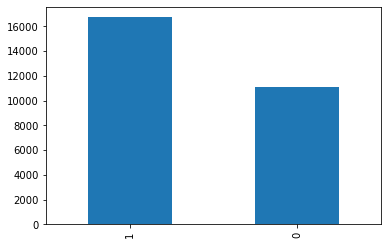

In [56]:
df_processed['label'].value_counts().plot(kind='bar')

### CountVectorizer

In [57]:
vect = CountVectorizer().fit(X_train)

In [58]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [59]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 20080
First 20 features:
['00', '000', '0000', '001', '005', '00am', '00p', '01', '038', '044', '054', '05pm', '07', '092', '10', '100', '1000', '100k', '100m', '100th']
Features 20010 to 20030:
['yogurt', 'yolks', 'yolo', 'yond', 'yonhap', 'yor', 'york', 'yorker', 'yorkers', 'yorkiest', 'young', 'younger', 'youngest', 'yourselfers', 'youth', 'youthful', 'youtube', 'youtuber', 'youtubers', 'yr']
Every 2000th feature:
['00', 'barra', 'commissioner', 'dynamics', 'gold', 'karins', 'namely', 'projections', 'session', 'thaw', 'yi']


In [60]:
X_train_vect = vect.transform(X_train)
print("X_train:\n{}".format(repr(X_train_vect)))

X_train:
<18662x20080 sparse matrix of type '<class 'numpy.int64'>'
	with 186412 stored elements in Compressed Sparse Row format>


### CountVectorizer / Logistic regression baseline

In [61]:
scores = cross_val_score(LogisticRegression(max_iter=5000), X_train_vect, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.80


In [62]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train_vect, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.80
Best parameters:  {'C': 1}


In [63]:
X_test_vect = vect.transform(X_test)
print("Test score: {:.2f}".format(grid.score(X_test_vect, y_test)))

Test score: 0.80


#### Count Vectorizer: min_df=5

In [64]:
vect_min5 = CountVectorizer(min_df=5).fit(X_train)
X_train_vect_min5 = vect_min5.transform(X_train)
print("X_train with min_df: {}".format(repr(X_train_vect_min5)))

X_train with min_df: <18662x6077 sparse matrix of type '<class 'numpy.int64'>'
	with 162602 stored elements in Compressed Sparse Row format>


In [65]:
feature_names_min5 = vect_min5.get_feature_names()

print("First 50 features:\n{}".format(feature_names_min5[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names_min5[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names_min5[::700]))

First 50 features:
['000', '10', '100', '103', '10th', '11', '110', '11th', '12', '120', '13', '130', '14', '149', '15', '150', '16', '160', '17', '170', '18', '180', '185', '18th', '19', '1960s', '1980s', '1984', '1999', '1mdb', '1st', '20', '200', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2025']
Features 20010 to 20030:
[]
Every 700th feature:
['000', 'birth', 'criminals', 'familiar', 'insider', 'mitch', 'promising', 'sick', 'treating']


In [66]:
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train_vect_min5, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.80


### TF-IDF Vectorizer / Logistic Regression

In [67]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=5000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.79


In [68]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset:
X_train_vect = vectorizer.transform(X_train)
# find maximum value for each of the features over dataset:
max_value = X_train_vect.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['via' 'according' 'even' 'know' 'breaking' 'plans' 'industry' 'second'
 'theresa' 'ever' 'record' 'north' 'makes' 'without' 'real' 'explains'
 'shows' 'find' 'stock' 'key']
Features with highest tfidf: 
['like' 'field' 'spring' 'waiting' 'dish' 'sudan' 'arab' 'metal'
 'juventus' 'dust' 'manchester' 'capital' 'fired' 'pakistan' 'stores'
 '000' 'best' 'wikileaks' 'tweets' 'network']


In [69]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['trump' 'says' 'new' 'china' 'world' 'one' 'people' 'via' 'year'
 'million' 'may' 'billion' 'first' 'could' 'time' 'make' 'years'
 'president' 'get' 'company' 'like' 'trade' '000' 'business' 'work' 'best'
 'said' 'us' 'two' 'biggest' 'companies' 'day' 'would' 'deal' 'back'
 'according' 'next' 'take' 'need' 'brexit' 'made' 'money' 'help' 'want'
 'market' 'say' 'top' 'oil' 'economy' '10' 'house' 'week' 'much'
 'facebook' 'bank' 'big' 'amazon' 'war' 'ceo' 'mueller' 'even' 'report'
 'way' 'know' 'former' 'today' 'apple' 'life' 'look' 'high' 'country'
 'government' 'since' 'tech' 'women' 'breaking' 'last' 'plan' 'america'
 'car' 'change' 'three' 'global' 'donald' 'see' 'things' 'employees'
 'google' 'chinese' 'many' 'better' 'watch' 'latest' 'job' 'become'
 'american' 'iran' 'leaders' 'state' 'good']


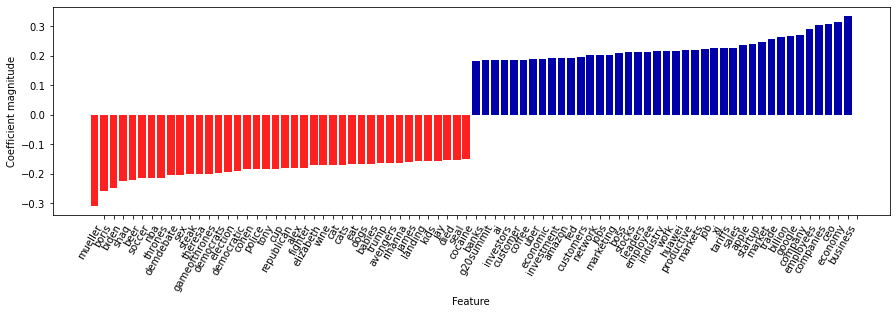

In [70]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

max_iter=5000

In [71]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
# param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
#               "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

# param_grid = {'logisticregression__C': [1, 10, 100],
#               "tfidfvectorizer__ngram_range": [(1, 1), (1, 2)]}

param_grid = {'logisticregression__C': [1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.80
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}


In [118]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
# param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
#               "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

# param_grid = {'logisticregression__C': [1, 10, 100],
#               "tfidfvectorizer__ngram_range": [(1, 1), (1, 2)]}

param_grid = {'logisticregression__C': [1],
              "tfidfvectorizer__ngram_range": [(1, 2)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.80
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}


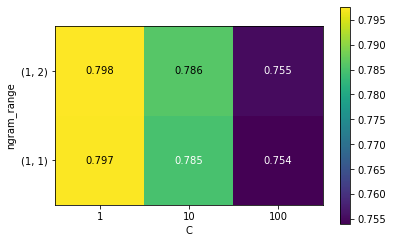

In [72]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 2).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

In [ ]:
# # extract scores from grid_search
# scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# # visualize heat map
# heatmap = mglearn.tools.heatmap(
#     scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
#     xticklabels=param_grid['logisticregression__C'],
#     yticklabels=param_grid['tfidfvectorizer__ngram_range'])
# plt.colorbar(heatmap)

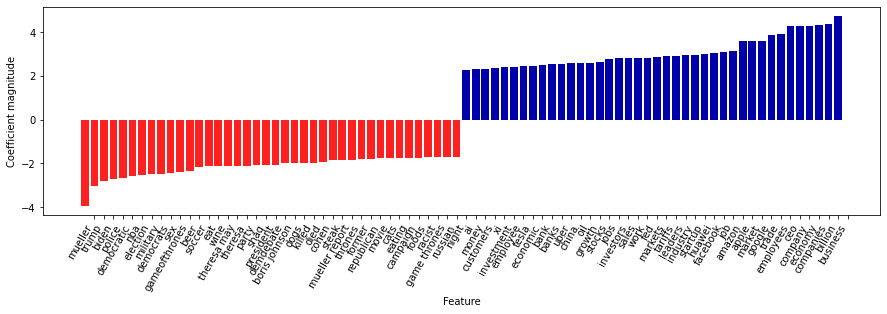

In [119]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)


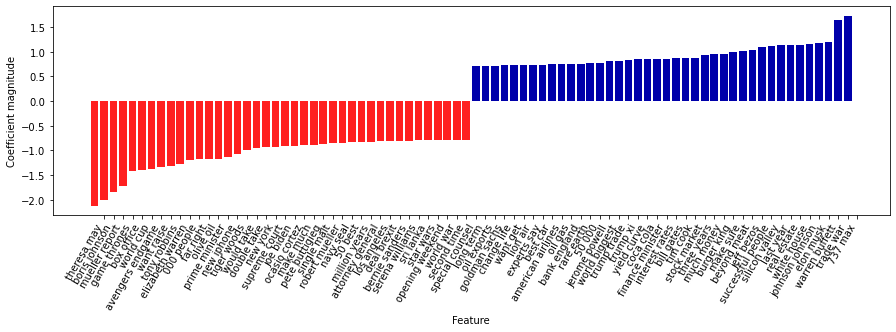

In [120]:
# find 2-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 2
# visualize only 2-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)


In [75]:
y_pred = grid.best_estimator_.predict(X_train)

In [76]:
print(confusion_matrix(y_train, y_pred))

[[ 5981  1516]
 [  832 10333]]


In [77]:
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

F-Measure: 0.898


In [78]:
y_test_pred = grid.best_estimator_.predict(X_test)

In [79]:
print(confusion_matrix(y_test, y_test_pred))

[[2492 1138]
 [ 690 4872]]


In [80]:
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

F-Measure: 0.842


In [81]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.78      0.69      0.73      3630
           1       0.81      0.88      0.84      5562

    accuracy                           0.80      9192
   macro avg       0.80      0.78      0.79      9192
weighted avg       0.80      0.80      0.80      9192



### Random Forest



Had an error running cell below. I didn't realize the specfic keys in param_grid:
https://stackoverflow.com/questions/64089009/how-can-i-tune-the-parameters-in-a-random-forest-classifier-inside-a-pipeline

In [82]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1, 1), (1, 2)],
              "randomforestclassifier__n_estimators": [800, 1000]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.78
Best parameters:
{'randomforestclassifier__n_estimators': 1000, 'tfidfvectorizer__ngram_range': (1, 1)}


In [83]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

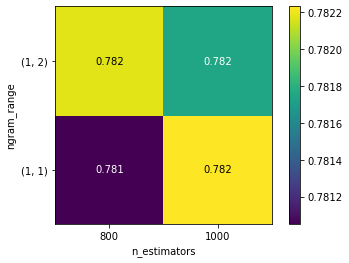

In [84]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 2).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="n_estimators", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['randomforestclassifier__n_estimators'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

#### Had to use feature_importances_ for Random Forest Classifier
https://towardsdatascience.com/present-the-feature-importance-of-the-random-forest-classifier-99bb042be4cc

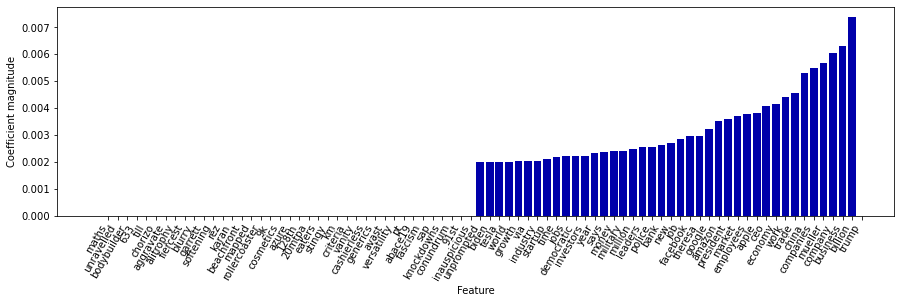

In [97]:
# extract feature names and feature_importances
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
feature_importances = grid.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
mglearn.tools.visualize_coefficients(feature_importances, feature_names, n_top_features=40)


In [98]:
feature_importances

array([5.74303855e-06, 1.11756459e-03, 1.38157625e-05, ...,
       1.35970966e-06, 1.38592628e-06, 2.99172522e-06])

In [99]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[ 7497     0]
 [    2 11163]]
F-Measure: 1.000


In [96]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[2586 1044]
 [ 858 4704]]
F-Measure: 0.832


In [89]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      3630
           1       0.80      0.85      0.82      5562

    accuracy                           0.78      9192
   macro avg       0.77      0.76      0.77      9192
weighted avg       0.78      0.78      0.78      9192



In [91]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__min_df": [1, 5, 10],
              "randomforestclassifier__n_estimators": [1000, 1200],
              "randomforestclassifier__max_features": [100, 200],
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.79
Best parameters:
{'randomforestclassifier__max_features': 100, 'randomforestclassifier__n_estimators': 1000, 'tfidfvectorizer__min_df': 1}


In [92]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[ 7497     0]
 [    2 11163]]
F-Measure: 1.000


In [93]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[2586 1044]
 [ 858 4704]]
F-Measure: 0.832


In [94]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      3630
           1       0.82      0.85      0.83      5562

    accuracy                           0.79      9192
   macro avg       0.78      0.78      0.78      9192
weighted avg       0.79      0.79      0.79      9192



In [95]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [101]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"randomforestclassifier__n_estimators": [800, 1000],
              "randomforestclassifier__max_features": [50, 100],
              "randomforestclassifier__max_depth": [5, 10],
              "randomforestclassifier__min_samples_leaf": [5, 10]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.60
Best parameters:
{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 100, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 1000}


In [102]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[   64  7433]
 [    0 11165]]
F-Measure: 0.750


In [103]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[  16 3614]
 [   0 5562]]
F-Measure: 0.755


In [104]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       1.00      0.00      0.01      3630
           1       0.61      1.00      0.75      5562

    accuracy                           0.61      9192
   macro avg       0.80      0.50      0.38      9192
weighted avg       0.76      0.61      0.46      9192



In [105]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=1100, max_features=125))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"randomforestclassifier__min_samples_leaf": [1,5]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.79
Best parameters:
{'randomforestclassifier__min_samples_leaf': 1}


In [106]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [107]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[ 7497     0]
 [    2 11163]]
F-Measure: 1.000


In [108]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[2602 1028]
 [ 876 4686]]
F-Measure: 0.831


In [109]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.75      0.72      0.73      3630
           1       0.82      0.84      0.83      5562

    accuracy                           0.79      9192
   macro avg       0.78      0.78      0.78      9192
weighted avg       0.79      0.79      0.79      9192




- n_estimators: In general the more trees the less likely the algorithm is to overfit. So try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set.
    
- max_features: try reducing this number (try 30-50% of the number of features). This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting.

- max_depth: Experiment with this. This will reduce the complexity of the learned models, lowering over fitting risk. Try starting small, say 5-10, and increasing you get the best result.

- min_samples_leaf: Try setting this to values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.


In [110]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=1500, max_features=0.4))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"randomforestclassifier__min_samples_leaf": [1]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.77
Best parameters:
{'randomforestclassifier__min_samples_leaf': 1}


In [111]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('Train F-Measure: %.3f' % score_train)

[[ 7496     1]
 [    1 11164]]
F-Measure: 1.000


In [112]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('Test F-Measure: %.3f' % score_test)

[[2483 1147]
 [ 875 4687]]
F-Measure: 0.823


In [113]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      3630
           1       0.80      0.84      0.82      5562

    accuracy                           0.78      9192
   macro avg       0.77      0.76      0.77      9192
weighted avg       0.78      0.78      0.78      9192



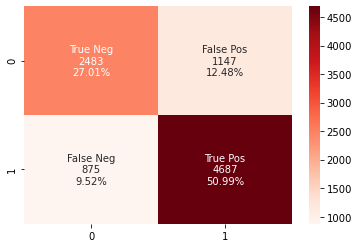

In [117]:
#heatmap for confusion matrix
results = confusion_matrix(actual, predicted) 

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                results.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='', cmap='Reds')

In [114]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

### XGBoost

In [106]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), XGBClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1,1), (1, 2)],
              "xgbclassifier__n_estimators": [1000, 1200, 1400]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__n_estimators': 1400}


In [107]:

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [108]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[1573  962]
 [  87 5592]]
F-Measure: 0.914


In [109]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[ 442  775]
 [ 210 2620]]
F-Measure: 0.842


In [110]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.68      0.36      0.47      1217
           1       0.77      0.93      0.84      2830

    accuracy                           0.76      4047
   macro avg       0.72      0.64      0.66      4047
weighted avg       0.74      0.76      0.73      4047



In [111]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), XGBClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1,1)],
              "xgbclassifier__n_estimators": [1400, 1600],
              "xgbclassifier__max_depth": [1, 5],
              "xgbclassifier__scale_pos_weight": [1, 5]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 1400, 'xgbclassifier__scale_pos_weight': 1}


In [112]:

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [113]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[1941  594]
 [  45 5634]]
F-Measure: 0.946


In [114]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[ 502  715]
 [ 269 2561]]
F-Measure: 0.839


In [115]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.65      0.41      0.51      1217
           1       0.78      0.90      0.84      2830

    accuracy                           0.76      4047
   macro avg       0.72      0.66      0.67      4047
weighted avg       0.74      0.76      0.74      4047



In [116]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), XGBClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1,1)],
              "xgbclassifier__n_estimators": [1400, 1600],
              "xgbclassifier__max_depth": [5, 10],
              "xgbclassifier__scale_pos_weight": [1, 2]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 1400, 'xgbclassifier__scale_pos_weight': 1}


In [117]:

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [118]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[1941  594]
 [  45 5634]]
F-Measure: 0.946


In [119]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[ 502  715]
 [ 269 2561]]
F-Measure: 0.839


In [ ]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), XGBClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1,1)],
              "xgbclassifier__n_estimators": [1400]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

### Best model

In [ ]:

===

TFIDF (min_df=5) and XGBoost
 {'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__n_estimators': 1400}
 
Train
F-Measure: 0.914
[[1573  962]
 [  87 5592]]

Test
F-Measure: 0.842
[[ 442  775]
 [ 210 2620]]
